# Corrélations entre les couples de variables

In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np
import seaborn as sns
import geopy.distance
import plotly.express as px

import matplotlib.pyplot as plt

import urllib.request
import json

# Récupération des données 

In [2]:
db_name = "../database/e-commerce.db"

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    # YOUR CODE
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
        return conn
    except Error as e:
        print(e)
        


conn = create_connection(db_name)
conn

2.6.0


In [6]:
    cur = conn.cursor()
#     the table wight_cm can become width_cm   --> order_delivered_carrier_date == order_delivered_customer_date
    cur.execute('''
                SELECT 
                order_item.item_id, 
                order_item.freight_value, 
                order_item.price, 
                weight_g,
                lenght_cm, 
                height_cm, 
                width_cm, 
                customer.zip_code, 
                seller.zip_code, 
                order_dataset.purchase_timestamp,
                order_dataset.order_estimated_delivery_date, 
                order_dataset.order_delivered_customer_date
                FROM product
                LEFT JOIN order_item ON product.id = order_item.product_id
                LEFT JOIN order_dataset ON order_item.order_id = order_dataset.order_id
                LEFT JOIN customer ON customer.id = order_dataset.customer_id          
                LEFT JOIN seller ON order_item.seller_id = seller.id                
                ''')
    
    res_cur = cur.fetchall()

OperationalError: no such table: product

In [7]:
df_bdd = pd.DataFrame(res_cur, columns=["nb_product", "prix_de_livraison", "product_price", "weight", "lenght", "height", "width", "zip_code_customer", "zip_code_seller", "date_purchase", "date_delevery_estimate", "date_delivery"])

NameError: name 'res_cur' is not defined

In [8]:
cur = conn.cursor()
#     the table wight_cm can become width_cm   --> order_delivered_carrier_date == order_delivered_customer_date
cur.execute('''
            SELECT 
            zip_code, latitude, longitude
            FROM geolocation
            ''')

res_cur = cur.fetchall()

df_geoloc = pd.DataFrame(res_cur, columns=["zip_code", "latitude", "longitude"])

OperationalError: no such table: geolocation

In [ ]:
df_bdd = df_bdd.merge(df_geoloc.drop_duplicates(['zip_code']), left_on='zip_code_customer', right_on='zip_code', how="left", suffixes = ("","_customer"))

In [ ]:
df_bdd = df_bdd.merge(df_geoloc.drop_duplicates(['zip_code']), left_on='zip_code_seller', right_on='zip_code', how="left", suffixes = ("","_seller"))

In [ ]:
df_bdd = df_bdd.rename({'latitude': 'latitude_customer', 'longitude': 'longitude_customer'}, axis=1)

In [ ]:
distance = {"distance" : []
           }


for latitude_customer, longitude_customer, latitude_seller, longitude_seller in df_bdd[["latitude_customer","longitude_customer", "latitude_seller", "longitude_seller"]].to_numpy():
    coords_1 = (float(latitude_customer), float(longitude_customer))
    coords_2 = (float(latitude_seller), float(longitude_seller))
    try:
        res = geopy.distance.geodesic(coords_1, coords_2).km
        distance["distance"].append(res)
    except:
        distance["distance"].append(np.nan)
    
df_bdd["distance"] = distance["distance"]

In [ ]:
days = []
for date_purchase, date_delivery in df_bdd[["date_purchase", "date_delivery"]].to_numpy():
    try:
        res = pd.to_datetime(date_delivery) - pd.to_datetime(date_purchase)
        res = str(res).split(" ")[0]
        days.append(int(res))
    except:         
        days.append(np.nan)

        
df_bdd["days_to_delivery"] = days
df_bdd

In [ ]:
df_features = df_bdd[['prix_de_livraison','weight','lenght','height','width', 'distance', 'days_to_delivery','nb_product','product_price']]

## Ajout de la feature volume

In [ ]:
df_features = df_features.assign(volume_cm3 = df_features['width'] * df_features['height'] * df_features['lenght'] )

In [ ]:
df_features

In [ ]:
# Suppression des lignes qui on au moins une valeurs nan
df_features = df_features.dropna()
df_features

## Création de la matrice de corrélation 

In [ ]:
mask = np.triu(np.ones_like(df_features.corr()))
heatmap = sns.heatmap(df_features.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

On voit que le volume est très correlé au poids, nous allons pas garder cette feature car même si elle simplifie les datas elle nous fait perdre de l'information. Les autres features ne semblent pas trop corrélées nous allons les garder.

In [ ]:
# Suppresion de la feature volume.
df_features.drop(['volume_cm3'], axis=1, inplace=True)
df_features

# Détermination des outliers

## Détermination de la normalité des valeurs

On commence par derterminer si nos données suivent une loi normale, pour les cibles : prix de la livraison et délai de livraison.

Contrôler la normalité des échantillons
La p-value renvoyer par le test de shapiro doit être supérieur à 0.05 pour rester sur l'hypothèse nulle d'une distribution normale.

In [ ]:
import scipy.stats

In [ ]:
scipy.stats.shapiro(df_features.prix_de_livraison)

Nous avons trop de données pour utiliser cette méthode. Nous allons visualiser la distribution des données. 

In [ ]:
px.histogram(df_features, x= 'prix_de_livraison')

Le prix de livraison ne semble pas suivre une loi normale.

In [ ]:
scipy.stats.shapiro(df_features.days_to_delivery)

In [ ]:
px.histogram(df_features, x= 'days_to_delivery')

Le delai de livraison ne semble pas suivre non plus un loi normale. Nos cibles ne suivant pas une loi normale, nous n'allons pas utiliser de Z score mais la méthode des quartilles.

In [ ]:
# sauvergarde des données dans un csv pour éviter de lancer la récupération des datas à chaque fois.
df_features.to_csv('/Users/justinelv/Documents/simplon/brief/Brief_13 LA DATA DREAM/LA-DATA-DREAM-TEAM-equipe-justine/features.csv', index=False)

In [9]:
# création d'un dataframe à partir du csv.
df_outliers = pd.read_csv('/Users/justinelv/Documents/simplon/brief/Brief_13 LA DATA DREAM/LA-DATA-DREAM-TEAM-equipe-justine/features.csv')

In [10]:
df_outliers.describe()

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,nb_product,product_price
count,109642.000000,109642.000000,109642.000000,109642.000000,109642.000000,109642.000000,109642.000000,109642.000000,109642.000000
mean,19.941298,2087.997911,30.134246,16.575646,22.975894,595.343458,11.999197,1.198482,119.999263
std,15.711804,3736.537873,16.114042,13.419416,11.661038,588.416264,9.450331,0.707701,182.415633
min,0.000000,0.000000,7.000000,2.000000,6.000000,0.000000,0.000000,1.000000,0.850000
25%,13.070000,300.000000,18.000000,8.000000,15.000000,184.031356,6.000000,1.000000,39.900000
50%,16.250000,700.000000,25.000000,13.000000,20.000000,431.603807,10.000000,1.000000,74.900000
75%,21.150000,1800.000000,38.000000,20.000000,30.000000,790.195715,15.000000,1.000000,134.550000
max,409.680000,40425.000000,105.000000,105.000000,118.000000,8711.002674,209.000000,21.000000,6735.000000


## Calcul des outliers 

In [11]:
#On calcule Q1

q1_prix =df_outliers["prix_de_livraison"].quantile(0.25)

#On calcule Q3

q3_prix =df_outliers["prix_de_livraison"].quantile(0.75)

#On calcule l'écart interquartile (IQR)

IQR_prix=q3_prix-q1_prix

#On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile

borne_inf_prix = q1_prix-1.5*IQR_prix

#On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile

borne_sup_prix = q3_prix +1.5*IQR_prix

#On regarde les valeurs à l'extérieur de la borne inférieure et supérieure

df_outliers_prix = df_outliers[df_outliers["prix_de_livraison"]>borne_sup_prix]
df_outliers_prix = df_outliers[df_outliers["prix_de_livraison"]<borne_inf_prix]

df_outliers_prix
print(len(df_outliers_prix))

510


In [12]:
df_outliers_prix.describe()

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,nb_product,product_price
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.062196,1934.447059,28.164706,14.345098,21.576471,652.207142,11.921569,1.507843,96.440843
std,0.169195,3442.235748,14.499249,8.678640,9.978417,521.233568,6.235846,1.190556,62.615923
min,0.000000,50.000000,15.000000,2.000000,11.000000,10.096315,1.000000,1.000000,7.000000
25%,0.000000,584.000000,16.000000,10.000000,13.000000,318.607769,8.000000,1.000000,69.900000
50%,0.000000,584.000000,20.000000,11.000000,16.000000,500.886212,11.000000,1.000000,99.900000
75%,0.010000,2600.000000,37.750000,13.000000,30.000000,831.595090,15.000000,2.000000,109.675000
max,0.920000,29700.000000,105.000000,78.000000,82.000000,2378.850632,48.000000,10.000000,712.900000


In [13]:
#On calcule Q1

q1_days=df_outliers["days_to_delivery"].quantile(0.25)

#On calcule Q3

q3_days=df_outliers["days_to_delivery"].quantile(0.75)

#On calcule l'écart interquartile (IQR)

IQR_days=q3_days-q1_days

#On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile

borne_inf_days = q1_days-1.5*IQR_days

#On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile

borne_sup_days = q3_days +1.5*IQR_days

#On regarde les valeurs à l'extérieur de la borne inférieure et supérieure

df_outliers_days = df_outliers[df_outliers["days_to_delivery"]>borne_sup_days]
df_outliers_days = df_outliers[df_outliers["days_to_delivery"]<borne_inf_days]

print(len(df_outliers_days))

0


La cible prix de livraison continent 510 outliers et la cible délai de livraison contient 0 outliers.

Pour traiter les outilers nous avons 3 solutions : DROP(les supprimer tous), CAP(supprimer), REPLACE (les remplacer par d'autres valeurs. Les outliers ne sont pas trop nombreux par rapport au nombre total de lignes, je vais simplement les supprimer.

# Drop outliers

In [14]:
#On supprime les valeurs aberrantes
#On calcule Q1

q1=df_outliers["prix_de_livraison"].quantile(0.25)

#On calcule Q3

q3=df_outliers["prix_de_livraison"].quantile(0.75)

#On calcule l'écart interquartile (IQR)

IQR=q3-q1

#On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile

borne_inf = q1-1.5*IQR

#On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile

borne_sup = q3 +1.5*IQR

#On garde les valeurs à l'intérieur de la borne inférieure et supérieure

df_without_outliers_prix = df_outliers[df_outliers["prix_de_livraison"]<borne_sup]
df_without_outilers_prix = df_outliers[df_outliers["prix_de_livraison"]>borne_inf]

In [15]:
df_without_outilers_prix

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,nb_product,product_price
0,7.39,225.0,16.0,10.0,14.0,141.206907,3.0,1,10.91
1,17.99,1000.0,30.0,18.0,20.0,361.255505,15.0,1,248.00
2,7.82,154.0,18.0,9.0,15.0,22.395881,2.0,1,79.80
3,9.54,371.0,26.0,4.0,26.0,74.618935,3.0,1,112.30
4,8.29,625.0,20.0,17.0,13.0,9.184295,2.0,1,37.90
...,...,...,...,...,...,...,...,...,...
109637,16.11,700.0,31.0,13.0,20.0,267.777831,12.0,2,29.90
109638,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,1,29.90
109639,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,2,29.90
109640,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,3,29.90


In [16]:
df_without_outilers_prix.describe()

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,nb_product,product_price
count,109132.000000,109132.000000,109132.000000,109132.000000,109132.000000,109132.000000,109132.000000,109132.000000,109132.000000
mean,20.034197,2088.715491,30.143450,16.586070,22.982434,595.077721,11.999560,1.197037,120.109357
std,15.689452,3737.858549,16.120704,13.436802,11.667977,588.701451,9.462808,0.704358,182.784233
min,0.960000,0.000000,7.000000,2.000000,6.000000,0.000000,0.000000,1.000000,0.850000
25%,13.100000,300.000000,18.000000,8.000000,15.000000,182.383997,6.000000,1.000000,39.900000
50%,16.280000,700.000000,25.000000,13.000000,20.000000,431.005574,10.000000,1.000000,74.900000
75%,21.150000,1800.000000,38.000000,20.000000,30.000000,789.994070,15.000000,1.000000,134.900000
max,409.680000,40425.000000,105.000000,105.000000,118.000000,8711.002674,209.000000,21.000000,6735.000000


<AxesSubplot:xlabel='prix_de_livraison'>

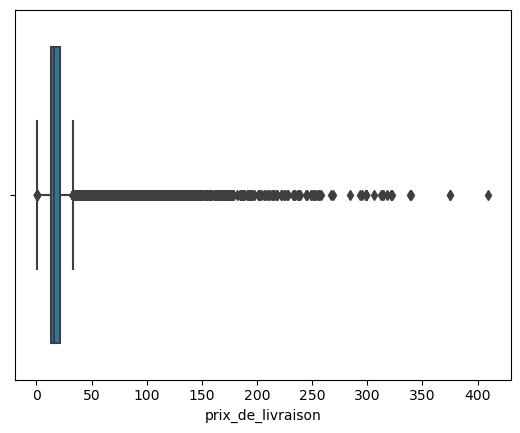

In [17]:
sns.boxplot(x =df_without_outilers_prix.prix_de_livraison)

On peut voir qu'il y a encore les valeurs hautes, les premiere outliers consernaient les valeurs bases (entre 0 et 0.92). Je vais refaire une recherche d'outliers pour voir si les valeirs hautes resortent.

In [18]:
#On calcule Q1

q1_prix2 =df_without_outilers_prix["prix_de_livraison"].quantile(0.25)

#On calcule Q3

q3_prix2 =df_without_outilers_prix["prix_de_livraison"].quantile(0.75)

#On calcule l'écart interquartile (IQR)

IQR_prix2 =q3_prix2-q1_prix2

#On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile

borne_inf_prix2 = q1_prix2-1.5*IQR_prix2

#On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile

borne_sup_prix2 = q3_prix2 +1.5*IQR_prix2

#On regarde les valeurs à l'extérieur de la borne inférieure et supérieure

df_outliers_prix2 = df_without_outilers_prix[df_without_outilers_prix["prix_de_livraison"]>borne_sup_prix2]
df_outliers_prix2 = df_without_outilers_prix[df_without_outilers_prix["prix_de_livraison"]<borne_inf_prix2]

df_outliers_prix2
print(len(df_outliers_prix2))

9


In [19]:
df_outliers_prix2.describe()

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,nb_product,product_price
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.983333,211.333333,17.333333,8.555556,14.888889,206.012667,6.555556,2.777778,48.507778
std,0.017321,138.974818,1.118034,3.678013,2.420973,259.500321,5.410894,1.787301,38.360787
min,0.960000,50.000000,16.000000,4.000000,12.000000,10.785721,2.000000,1.000000,22.900000
25%,0.970000,107.000000,17.000000,5.000000,14.000000,35.836004,2.000000,2.000000,24.990000
50%,0.980000,150.000000,17.000000,9.000000,14.000000,36.157703,3.000000,2.000000,39.900000
75%,1.000000,383.000000,18.000000,11.000000,16.000000,281.345173,11.000000,4.000000,47.990000
max,1.010000,400.000000,19.000000,13.000000,20.000000,780.425994,15.000000,6.000000,146.990000


La seconde analyses des outliers sur la colonne prix de livraison ne permet d'identifier les valeurs hautes comme outliers je vais donc les laisser.

<AxesSubplot:xlabel='weight'>

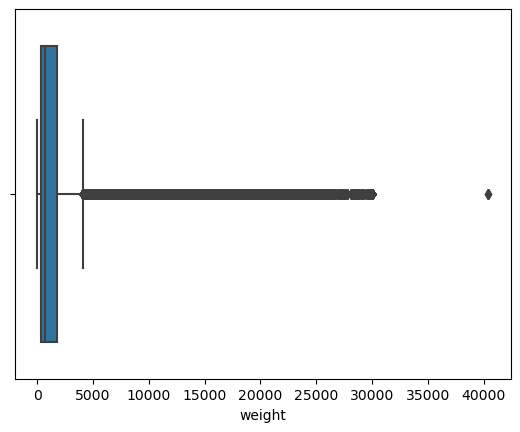

In [20]:
# Visualisation des valeurs de poids, nous allons tester les outliers pour le poids. 
sns.boxplot(x =df_without_outilers_prix.weight)

In [21]:
#On calcule Q1

q1_poids =df_without_outilers_prix["weight"].quantile(0.25)

#On calcule Q3

q3_poids =df_without_outilers_prix["weight"].quantile(0.75)

#On calcule l'écart interquartile (IQR)

IQR_poids =q3_poids-q1_poids

#On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile

borne_inf_poids = q1_poids-1.5*IQR_poids

#On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile

borne_sup_poids = q3_poids +1.5*IQR_poids

#On regarde les valeurs à l'extérieur de la borne inférieure et supérieure

df_outliers_poids = df_without_outilers_prix[df_without_outilers_prix["weight"]>borne_sup_poids]
df_outliers_poids = df_without_outilers_prix[df_without_outilers_prix["weight"]<borne_inf_poids]

df_outliers_poids
print(len(df_outliers_poids))

0


Il n'y a pas d'outliers dans la colone weight, je vais le vérifier avec un autre code.

In [27]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [35]:
lower_range ,upper_range = outlier_treatment(df_outliers.weight)

In [36]:
lower_range

-1950.0

In [37]:
upper_range

4050.0

Cette seconde méthode trouve 15322 outiliers, la premiere méthode n'est peut être pas bonne. 

Nous allons tester d'enlever ces outliers même si il y en a beaucoup.

In [43]:
data_clean = df_outliers[df_outliers['weight'] < upper_range]

In [44]:
data_clean

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,nb_product,product_price
0,7.39,225.0,16.0,10.0,14.0,141.206907,3.0,1,10.91
1,17.99,1000.0,30.0,18.0,20.0,361.255505,15.0,1,248.00
2,7.82,154.0,18.0,9.0,15.0,22.395881,2.0,1,79.80
3,9.54,371.0,26.0,4.0,26.0,74.618935,3.0,1,112.30
4,8.29,625.0,20.0,17.0,13.0,9.184295,2.0,1,37.90
...,...,...,...,...,...,...,...,...,...
109637,16.11,700.0,31.0,13.0,20.0,267.777831,12.0,2,29.90
109638,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,1,29.90
109639,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,2,29.90
109640,23.28,700.0,31.0,13.0,20.0,1027.480004,17.0,3,29.90


In [45]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94193 entries, 0 to 109641
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prix_de_livraison  94193 non-null  float64
 1   weight             94193 non-null  float64
 2   lenght             94193 non-null  float64
 3   height             94193 non-null  float64
 4   width              94193 non-null  float64
 5   distance           94193 non-null  float64
 6   days_to_delivery   94193 non-null  float64
 7   nb_product         94193 non-null  int64  
 8   product_price      94193 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 7.2 MB


In [46]:
data_clean.describe()

,prix_de_livraison,weight,lenght,height,width,distance,days_to_delivery,nb_product,product_price
count,94193.000000,94193.000000,94193.000000,94193.000000,94193.000000,94193.000000,94193.000000,94193.000000,94193.000000
mean,17.029292,848.959710,27.554978,13.885958,20.868854,597.466208,11.724300,1.201788,101.334271
std,8.683236,815.147393,13.837981,9.490179,9.460304,590.527739,9.240629,0.717389,144.921206
min,0.000000,0.000000,7.000000,2.000000,6.000000,0.000000,0.000000,1.000000,0.850000
25%,12.690000,250.000000,18.000000,8.000000,14.000000,181.149171,6.000000,1.000000,35.900000
50%,15.540000,533.000000,22.000000,12.000000,18.000000,435.537524,10.000000,1.000000,64.900000
75%,18.940000,1200.000000,33.000000,18.000000,26.000000,795.134516,15.000000,1.000000,117.000000
max,209.630000,4037.000000,105.000000,105.000000,118.000000,8002.649447,209.000000,21.000000,4590.000000


<AxesSubplot:xlabel='weight'>

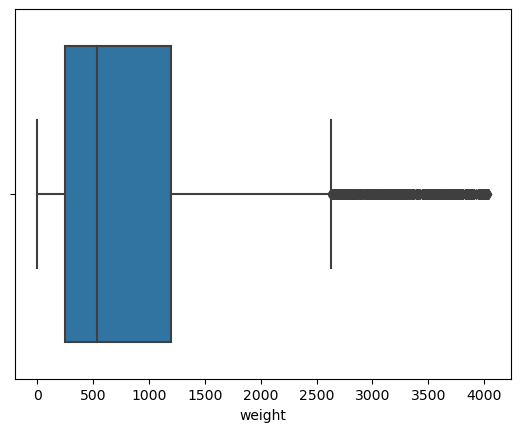

In [47]:
 sns.boxplot(x =data_clean.weight)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prix_de_livraison'>

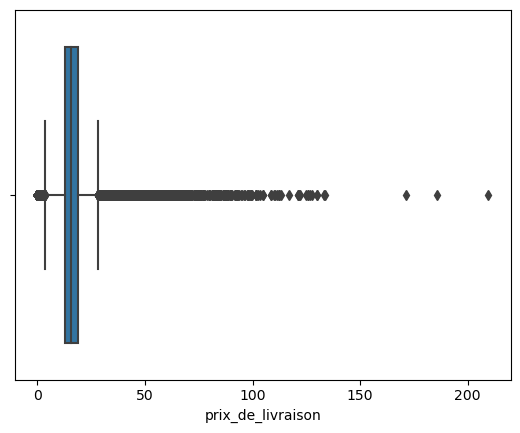

In [50]:
 sns.boxplot(data_clean.prix_de_livraison)

In [51]:
# sauvergarde des données dans un csv
data_clean.to_csv('/Users/justinelv/Documents/simplon/brief/Brief_13 LA DATA DREAM/LA-DATA-DREAM-TEAM-equipe-justine/data_clean.csv', index=False)

Voila, ce nouveau fichier CSV va nous servir à entrainer les modèles avec un nouveau set de données nettoyées. 